In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from data_preprocessing import get_X_y
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score



In [3]:
X, y = get_X_y()
X.head()
df = pd.DataFrame(X,y)
df.shape
X.columns

Index(['year', 'length_ft', 'beam_ft', 'numEngines', 'totalHP',
       'created_month', 'created_year', 'type_power', 'type_sail',
       'boatClass_power-aft',
       ...
       'zip_98362', 'zip_98382', 'zip_98402', 'zip_98408', 'zip_98501',
       'zip_98502', 'zip_98516', 'zip_99336', 'zip_99501', 'zip_99508'],
      dtype='object', length=977)

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=0.8, random_state=0)


In [4]:
n_comp = 18
print('number of components', n_comp)

number of components 18


In [5]:
cols = ['PC-'+str(i+1) for i in range(n_comp)]
cols


['PC-1',
 'PC-2',
 'PC-3',
 'PC-4',
 'PC-5',
 'PC-6',
 'PC-7',
 'PC-8',
 'PC-9',
 'PC-10',
 'PC-11',
 'PC-12',
 'PC-13',
 'PC-14',
 'PC-15',
 'PC-16',
 'PC-17',
 'PC-18']

PC-1     0.30
PC-2     0.12
PC-3     0.09
PC-4     0.07
PC-5     0.05
PC-6     0.04
PC-7     0.03
PC-8     0.02
PC-9     0.02
PC-10    0.02
PC-11    0.01
PC-12    0.01
PC-13    0.01
PC-14    0.01
PC-15    0.01
PC-16    0.01
PC-17    0.01
PC-18    0.01
dtype: float64


<Axes: title={'center': 'PVE'}>

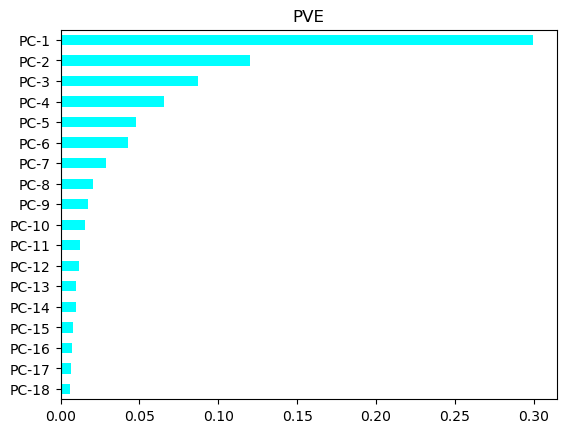

In [6]:
pca = PCA(n_components=n_comp)
pca.fit(X_train)
PVE = pca.explained_variance_ratio_
PVE = pd.Series(PVE,index=cols)
print(PVE.round(2))
PVE.sort_values().plot.barh(color='cyan',title='PVE')

In [7]:
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
Z_train = pd.DataFrame(Z_train, columns=cols)
Z_test = pd.DataFrame(Z_test, columns=cols)
lr = LinearRegression()
lr.fit(Z_train,y_train)
(Z_train.shape)

(4612, 18)

In [8]:
print(lr.score(Z_train, y_train))
print(lr.score(Z_test, y_test))

0.6495890477505155
0.6650747892280096


## Looking at loading scores

## Linear Regressor

In [9]:
def EvaluateR2(model,candidates,Z_train,y_train,R2_test,R2_train):
    features = model.copy()
    n = 0
    nums = [n]
    while n< len(candidates)-1:
        n=n+1
        nums.append(n)
        # fit regressor and evaluate R2
        features.append(candidates[n])
        lr.fit(Z_train[features],y_train)
        print(lr.score(Z_test[features],y_test))
        if lr.score(Z_test[features],y_test) <=R2_test[-1]:
            features.remove(candidates[n])
        else:
            lrBest = LinearRegression()
            lrBest.fit(Z_train[features],y_train)
            R2_train.append(lrBest.score(Z_train[features],y_train))
            R2_test.append(lrBest.score(Z_test[features],y_test))
           
        print(R2_test[-1])
        
    return (lrBest,features, nums,R2_test,R2_train,R2_test[-1],R2_train[-1])

In [10]:
candidates = list(Z_train.columns)
print(candidates)
R2_test=[]
R2_train=[]
model = [candidates[0]]
candidates.remove(candidates[0])
lr = LinearRegression()
lr.fit(Z_train[model],y_train)
R2_train.append(lr.score(Z_train[model],y_train))
R2_test.append(lr.score(Z_test[model],y_test))
(lrBest,featuresBest, nums,R2_test,R2_train,lastTest, lastTrain) = EvaluateR2(model,candidates,Z_train,y_train,R2_test,R2_train)


['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6', 'PC-7', 'PC-8', 'PC-9', 'PC-10', 'PC-11', 'PC-12', 'PC-13', 'PC-14', 'PC-15', 'PC-16', 'PC-17', 'PC-18']
0.5534892140911032
0.5534892140911032
0.5673942508088512
0.5673942508088512
0.567652061196447
0.567652061196447
0.5680706351271725
0.5680706351271725
0.6428303469574561
0.6428303469574561
0.6427325396318668
0.6428303469574561
0.6427960577034468
0.6428303469574561
0.6438468141402892
0.6438468141402892
0.646852304516752
0.646852304516752
0.6533926452930305
0.6533926452930305
0.6540458040121698
0.6540458040121698
0.653152267147007
0.6540458040121698
0.6554023544153585
0.6554023544153585
0.6566456432639263
0.6566456432639263
0.6552559632828117
0.6566456432639263
0.6570150263495591
0.6570150263495591


In [11]:
coeffs = pd.Series(lrBest.coef_,featuresBest)
coeffs.sort_values()

PC-12    -28693.588852
PC-4     -28301.858490
PC-5     -20579.264927
PC-13      4555.626991
PC-18     15364.930680
PC-15     17578.865133
PC-16     25000.785561
PC-6      25542.342061
PC-11     28386.948834
PC-10     61449.536796
PC-1      64919.003853
PC-3      69715.906831
PC-7     104081.618044
dtype: float64

## Random Forest


         best B = {'n_estimators': 100}
  validation R2 = 0.847


<Axes: xlabel='trees'>

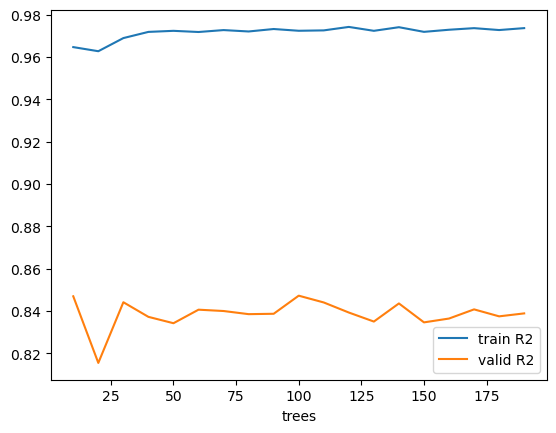

In [12]:
# cross-validate to determine optimal depth
B = np.arange(10,200,10)
grid = {'n_estimators':B}

rf = RandomForestRegressor(max_features = 1/3)    # 1/3 for regressor
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(Z_train,y_train)

print()
print('         best B =',rfCV.best_params_)
print('  validation R2 =',rfCV.best_score_.round(3))

results = pd.DataFrame()
results['trees'] = grid['n_estimators']
results['train R2'] = rfCV.cv_results_['mean_train_score']
results['valid R2']  = rfCV.cv_results_['mean_test_score']
results.plot.line(x='trees',y=['train R2','valid R2'])

In [13]:
# test R2
print('test R2',rfCV.score(Z_test,y_test).round(3))

test R2 0.823


## Boosting Trees 

In [14]:
#Boosting: Stage 1
tree1 = DecisionTreeRegressor(max_depth=2)
tree1.fit(Z_train,y_train)
yh1 = tree1.predict(Z_train)
yhTree= tree1.predict(Z_test)
R2 = r2_score(y_train,yh1)
R2_test = r2_score(y_test,yhTree)
print('Stage 1')
print('    Train R2',R2)
print('    Test R2',R2_test)

Stage 1
    Train R2 0.7139692506125856
    Test R2 0.4433500043536218


In [15]:
#Boosting Stage 2
dy1 = y_train - yh1
tree2 = DecisionTreeRegressor(max_depth=2)
tree2.fit(Z_train,dy1)
dy1h = tree2.predict(Z_train)
yh2 = yh1 + dy1h
## test
dy1hTest = tree2.predict(Z_test)
yh2Test = yhTree + dy1hTest
## scores
R2 = r2_score(y_train,yh2)
print('Stage 2')
print('    Train R2',R2)
R2_test = r2_score(y_test,yh2Test)
print('    Test R2',R2_test)

Stage 2
    Train R2 0.7846379988790583
    Test R2 0.5250910000848639


In [16]:
#Boosting Stage 3
dy2 = y_train - yh2
tree3 = DecisionTreeRegressor(max_depth=2)
tree3.fit(Z_train,dy2)
dy2h = tree3.predict(Z_train)
yh3 = yh2 + dy2h
# Test
dy2hTest = tree3.predict(Z_test)
yh3Test = yh2Test +dy2hTest


R2 = r2_score(y_train,yh3)
print('Stage 3')
print('    Train R2',R2)
R2_test = r2_score(y_test,yh3Test)
print('    Test R2',R2_test)

Stage 3
    Train R2 0.8156508265604665
    Test R2 0.5809620346087158


In [17]:
#Boosting Stage 4
dy3 = y_train - yh3
tree4 = DecisionTreeRegressor(max_depth=2)
tree4.fit(Z_train,dy3)
dy3h = tree4.predict(Z_train)
yh4 = yh3 + dy3h
# Test 
dy3hTest = tree4.predict(Z_test)
yh4Test = yh3Test +dy3hTest

R2 = r2_score(y_train,yh4)
print('Stage 4')
print('    Train R2',R2)
R2_test = r2_score(y_test,yh4Test)
print('    Test R2',R2_test)

Stage 4
    Train R2 0.8366081001802617
    Test R2 0.5440426046502884


In [18]:
#Boosting Stage 5
dy4 = y_train - yh4
tree5 = DecisionTreeRegressor(max_depth=2)
tree5.fit(Z_train,dy4)
dy4h = tree5.predict(Z_train)
yh5 = yh4 + dy4h
# Test 
dy4hTest = tree5.predict(Z_test)
yh5Test = yh4Test +dy4hTest

R2 = r2_score(y_train,yh5)
print('Stage 5')
print('    Train R2',R2)
R2_test = r2_score(y_test,yh5Test)
print('    Test R2',R2_test)

Stage 5
    Train R2 0.8564075132014741
    Test R2 0.5881755413624298


[Text(0.5, 0.8333333333333334, 'PC-7 <= 4.139\nsquared_error = 6744676946.733\nsamples = 4612\nvalue = 0.0'),
 Text(0.25, 0.5, 'PC-1 <= 7.827\nsquared_error = 6309663291.661\nsamples = 4607\nvalue = -486.392'),
 Text(0.125, 0.16666666666666666, 'squared_error = 5628059137.67\nsamples = 4589\nvalue = 777.911'),
 Text(0.375, 0.16666666666666666, 'squared_error = 75778654957.217\nsamples = 18\nvalue = -322813.372'),
 Text(0.75, 0.5, 'PC-7 <= 4.311\nsquared_error = 206499360000.011\nsamples = 5\nvalue = 448161.708'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.0\nsamples = 1\nvalue = 1290361.708'),
 Text(0.875, 0.16666666666666666, 'squared_error = 36467687500.0\nsamples = 4\nvalue = 237611.708')]

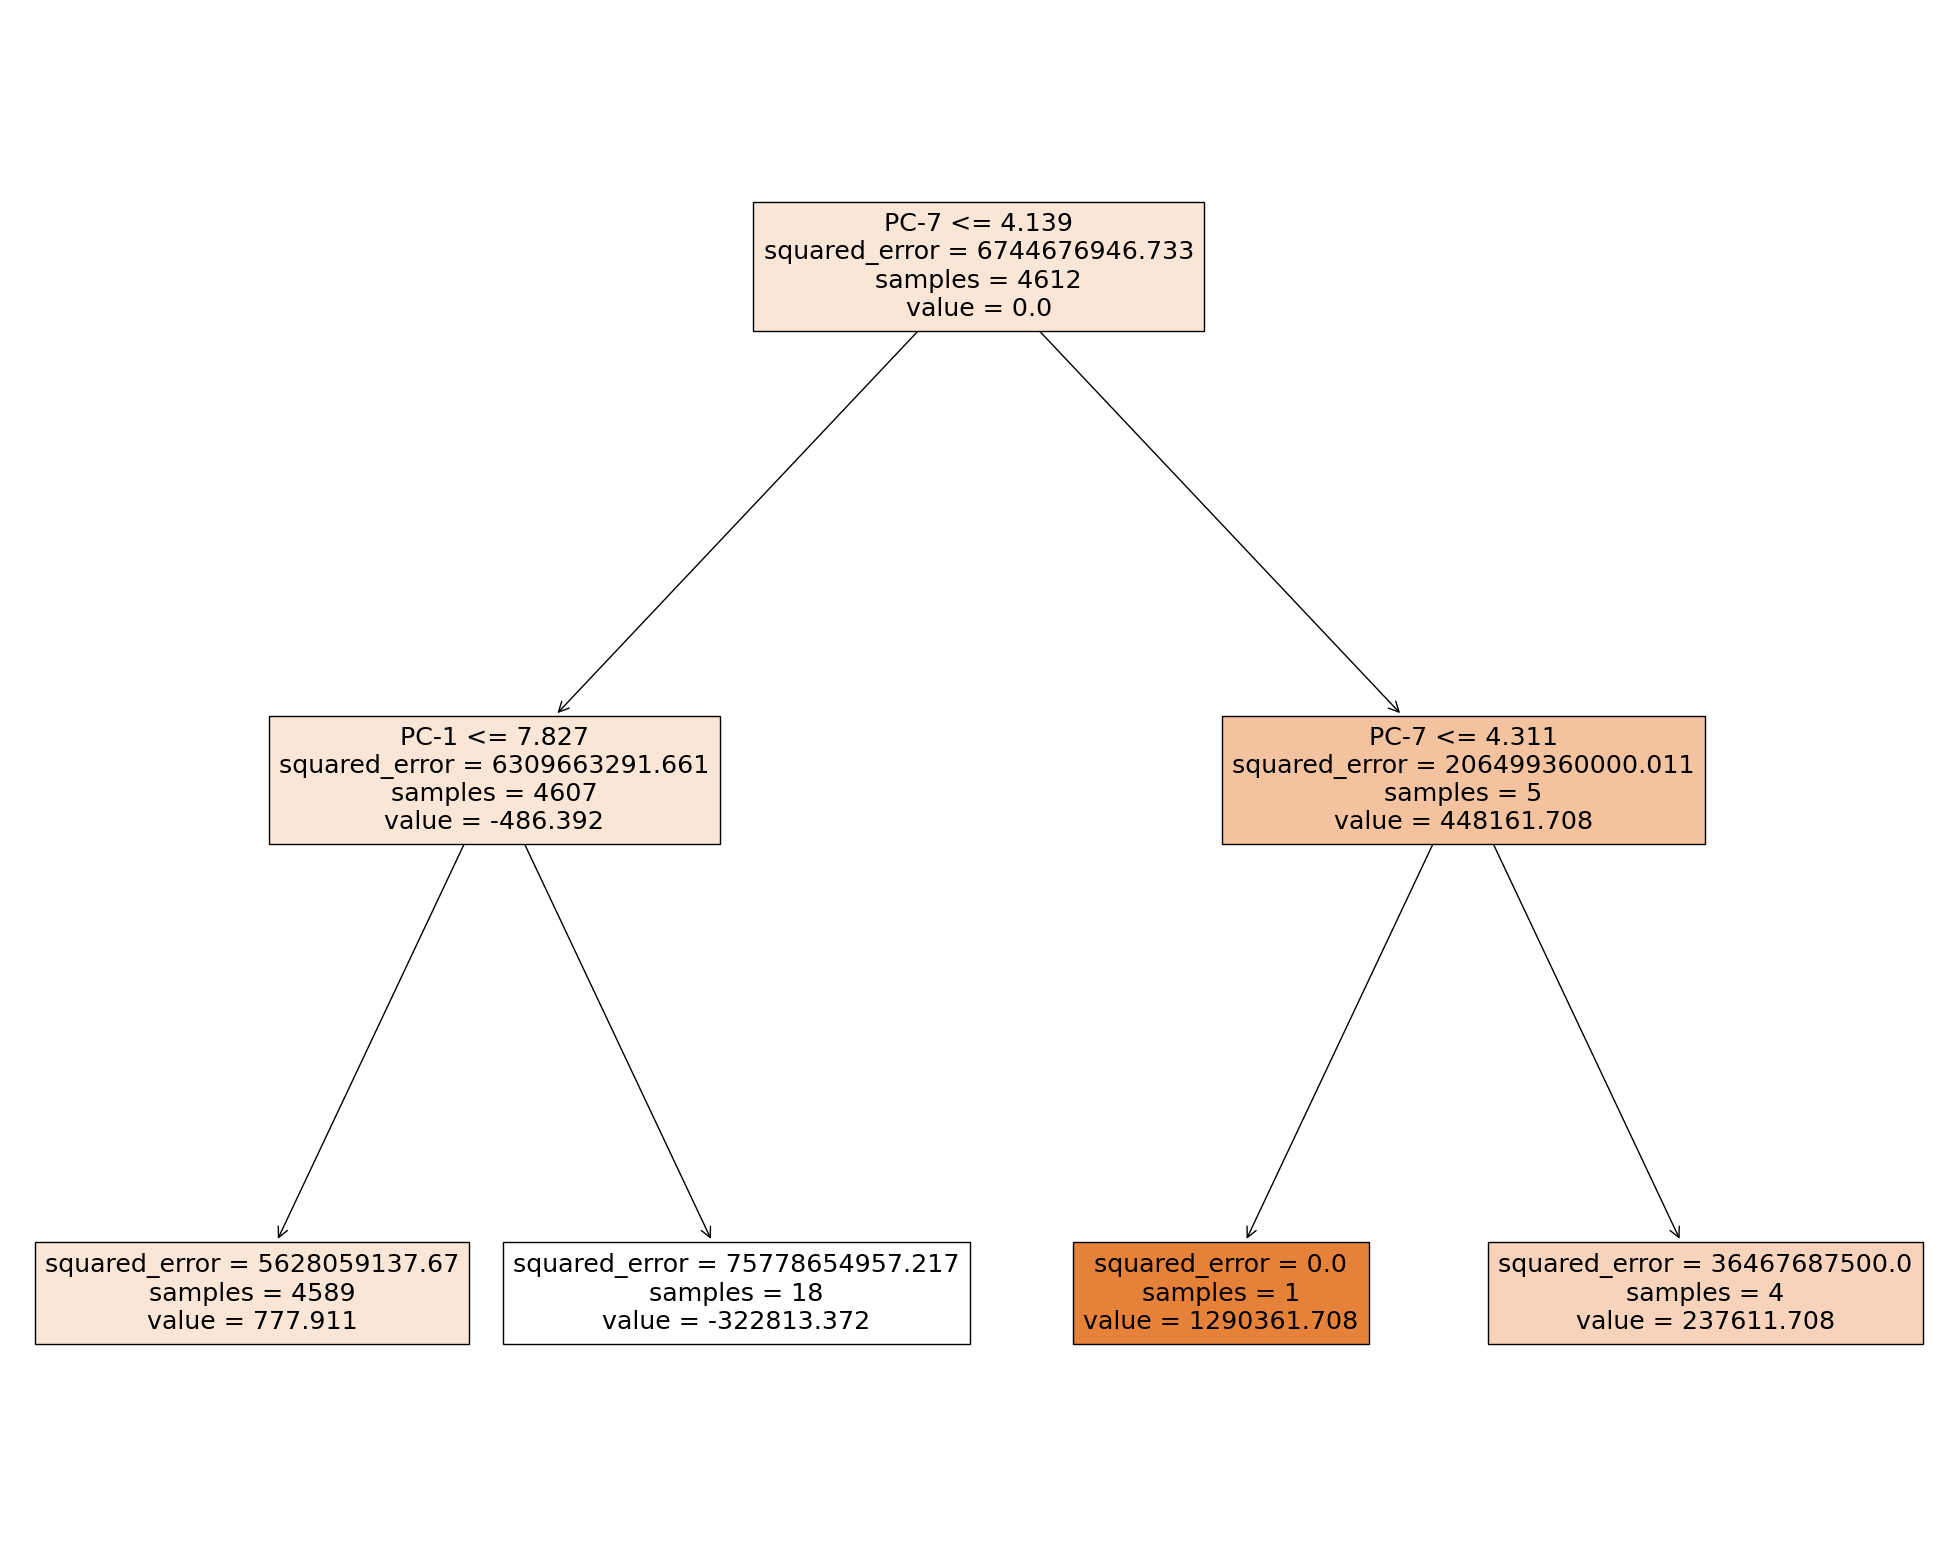

In [19]:
## Visualize Tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree5, feature_names = Z_train.columns, class_names = y_train, filled=True)

## Gradient Boosting Regressor

In [ ]:
grid = {'learning_rate':[0.01, 0.1,1],'n_estimators':[100,2000],'max_depth':[1,2,3]}

bgt = GradientBoostingRegressor()
gbtCV = GridSearchCV(bgt,param_grid=grid,n_jobs=-1)
gbtCV.fit(Z_train,y_train)

In [ ]:
print('Gradient Boosting Trees:')
print('    Optimal Parameters:',gbtCV.best_params_)
print('    Optimal Valid R2=',gbtCV.best_score_.round(3))
print('    Optimal Test R2=', gbtCV.score(Z_test,y_test))